In [1]:
import sys
sys.path.append("/fs/clip-controllablemt/IWSLT2022/scripts")

In [2]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer
)
import torch

In [3]:
def read_file(fname):
    data = []
    with open(fname) as f:
        for line in f:
            data.append(line.strip())
    return data

def get_data(tgt_lang, domain, split):
    source = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.en")
    formal_translations = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.formal.{tgt_lang}")
    informal_translations = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.informal.{tgt_lang}")
    return source, formal_translations, informal_translations

In [4]:
source, formal_translations, informal_translations = get_data("hi", "combined", "train")

In [5]:
model_dir="/fs/clip-controllablemt/IWSLT2022/models/xformal-regressor"
is_regression=True
cache_dir="/fs/clip-scratch/sweagraw/CACHE_en"

In [6]:
if is_regression:
    num_labels=1
else:
    num_labels=2

In [7]:
config = AutoConfig.from_pretrained(
        model_dir,
        num_labels=num_labels,
        cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(
    model_dir,
    from_tf=bool(".ckpt" in model_dir),
    config=config,
    cache_dir=cache_dir)

In [36]:
def classify(text):
    model_inputs = tokenizer(text, return_tensors="pt")
    logits=model(**model_inputs).logits
    return torch.softmax(logits, dim=1).tolist()[0]

In [38]:
classify(source[0])

[1.0]

Plot scores

In [5]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
def read_scores(fname):
    data = []
    with open(fname) as f:
        for line in f:
            data.append(float(line.strip()))
    return data

In [7]:
scores_dict = {}
for dir_name in glob.glob("../internal_split/*"):
    scores_dict[dir_name.split("/")[-1]] = {}
    for file_name in glob.glob(dir_name + "/*"):
        if file_name.endswith(".scores") and "combined" in file_name:
            scores_dict[dir_name.split("/")[-1]][file_name.split("/")[-1]] = read_scores(file_name)

In [8]:
# source formality train and dev
import numpy as np

def get_accuracy(scores_formal, scores_informal):
    print("Formal", sum(np.array(scores_formal) < 0.5)/ len(scores_formal))
    print("InFormal", sum(np.array(scores_informal) > 0.5)/ len(scores_informal))

def plot_scores(lang):
    src, tgt = lang.split("-")
    scores_src = scores_dict[lang]['dev.combined.' + src + '.scores']
    scores_formal = scores_dict[lang]['dev.combined.formal.' + tgt + '.finetune.scores']
    scores_informal = scores_dict[lang]['dev.combined.informal.' + tgt + '.finetune.scores']  
    get_accuracy(scores_formal, scores_informal)
    for data in [scores_src, scores_formal, scores_informal]:
        sns.histplot(data)
        plt.show()

Formal 0.98
InFormal 0.99


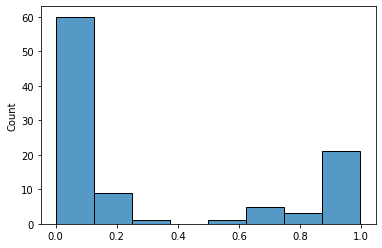

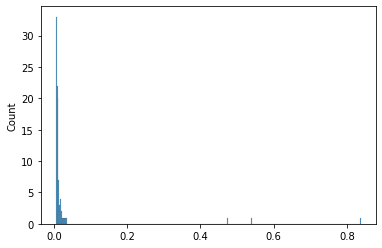

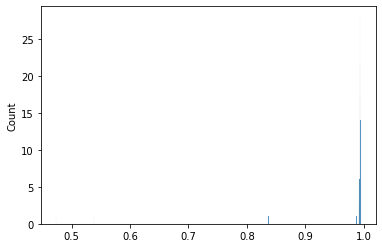

In [9]:
plot_scores('en-de')

Formal 0.98
InFormal 0.98


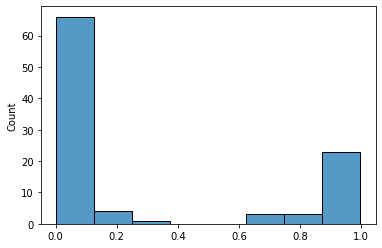

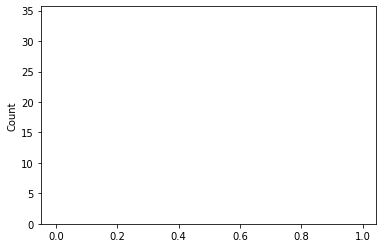

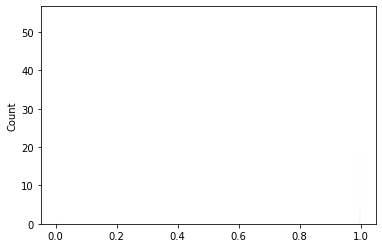

In [10]:
plot_scores('en-ja')

Formal 0.96
InFormal 0.95


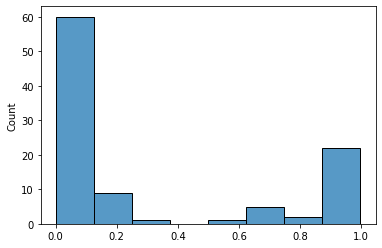

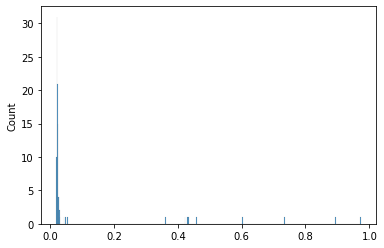

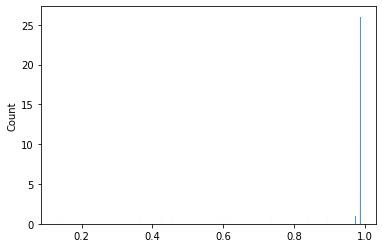

In [11]:
plot_scores('en-hi')

Formal 0.99
InFormal 0.92


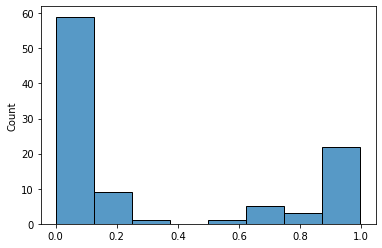

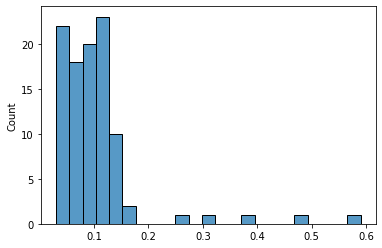

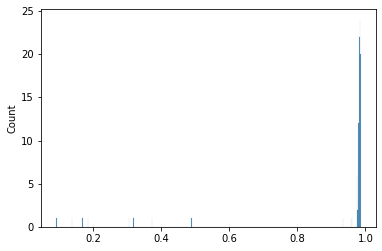

In [12]:
plot_scores('en-es')